# Projet : reseau de neurone


## Importation librairies

In [31]:
from math import log

import pandas as pd
from scale import Scale
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from utility import Utility
from scale import Scale


## 1. Préparation des données

In [32]:
# Notre dataframe
root = "../donnees/"
synthetic_df = pd.read_csv(root + "synthetic.csv")
synthetic_df,dico_coeffs = Scale.normalize(synthetic_df)

liste_attributs = list(synthetic_df.columns[:-1])

## récupération des donnée attributs (liste_attributs)
X = synthetic_df[liste_attributs]
Y = synthetic_df['Class']
Y= pd.get_dummies(Y) # transformer Y en des 0 et 1


X_t, X_test, Y_t, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train,X_validation, Y_train, Y_validation=train_test_split(X_t, Y_t, test_size=0.15, random_state=42)


## 2. La Classe Reseau de neurone

In [33]:
class ReseuDeNeurone:

    def __init__(self, X_train=None, Y_train=None, X_test=None, Y_test=None, X_validation=None, Y_validation=None,
                 hidden_layer_sizes=(4,), activation='identity', learning_rate=0.1,epoch=100):

        self.activation = self.fonction_activation(activation)
        self.X_train = X_train
        self.Y_train = Y_train

        self.X_test = X_test
        self.Y_test = Y_test

        self.X_validation = X_validation
        self.Y_validation = Y_validation

        self.epoch=epoch
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.n_layers = len(hidden_layer_sizes)

        self.df = [None] * (self.n_layers + 1)
        self.weights = [None] * (self.n_layers + 1)
        self.biais = [None] * (self.n_layers + 1)
        self.Matrice_Z = [None] * (self.n_layers + 1)
        self.Matrice_A = [None] * (self.n_layers + 1)

        self.__weights_initialization(X_train, Y_train)

        earling = self.earling_stoping(2, 3, self.X_train, self.Y_train, self.X_validation, self.Y_validation)


        #self.epoch_N()

        c=self.forward_promagation(self.X_test.T,self.Y_test.T)


    def __weights_initialization(self, X, Y):

        shape_couche = ((X.shape[1],) + self.hidden_layer_sizes + (Y.shape[1],))

        for i in range(len(self.weights)):
            self.weights[i] = np.random.uniform(low=-1.0, high=1.0, size=(shape_couche[i + 1], shape_couche[i]))

            self.biais[i] = np.random.uniform(low=-1.0, high=1.0, size=(shape_couche[i + 1], 1))

    def forward_promagation(self, X, Y):



        for i in range(len(self.Matrice_Z)):

            if (i == 0):

                self.Matrice_Z[i] = self.weights[i].dot(X) + self.biais[i]

                self.Matrice_A[i], self.df[i] = self.activation(self.Matrice_Z[i])

            else:

                self.Matrice_Z[i] = self.weights[i].dot(self.Matrice_A[i - 1]) + self.biais[i]
                self.Matrice_A[i], self.df[i] = self.activation((self.Matrice_Z[i]))

        self.Matrice_A[len(self.Matrice_A) - 1] = Utility.softmax(self.Matrice_Z[len(self.Matrice_Z) - 1])

        cost = Utility.cross_entropy_cost(self.Matrice_A[len(self.Matrice_A) - 1], Y)

        self.prediction=self.Matrice_A[len(self.Matrice_A) - 1]

        #print(self.Matrice_A[2].shape)
        #print(Y.shape)


        return cost

    def backward_pass(self, X, Y):

        L = self.n_layers
        delta = [None] * (self.n_layers + 1)
        dW = [None] * (self.n_layers + 1)
        db = [None] * (self.n_layers + 1)

        delta[L] = self.Matrice_A[L] - Y.T  # valable que pour softmax & entropie crois´ee!


        dW[L] = delta[L].dot(self.Matrice_A[L - 1].T)

        db[L] = delta[L]

        for l in range(L - 1, -1, -1):

            delta[l] = np.multiply(self.weights[l + 1].T.dot(delta[l + 1]), self.df[l])
            #print(delta[l])
            if (l == 0):

                dW[l] = delta[l].dot(X)
                db[l] = delta[l]

            else:

                dW[l] = delta[l].dot(self.Matrice_A[l - 1].T)
                db[l] = delta[l]

        #mise ajour des paramètre w et b
        for i in range(L + 1):
            self.weights[i] = self.weights[i] - self.learning_rate * dW[i]
            self.biais[i] = self.biais[i] - self.learning_rate * db[i]



    def entrainement(self, X_train, Y_train, n):
        liste_erreur_train = []

        for i in range(n):

            X_train, Y_train = shuffle(X_train,Y_train)
            Y_train = np.array(Y_train)
            X_train = np.array(X_train)

            for k in range(len(X_train)):
                X = X_train[k].reshape(X_train.shape[1], 1)
                Y = Y_train[k].reshape(Y_train.shape[1], 1)
                liste_erreur_train.append(self.forward_promagation(X, Y))
                self.backward_pass(X.T, Y.T)

        return sum(liste_erreur_train) / len(liste_erreur_train)

    def validation(self,X_validation,Y_validation):

        X_validation, Y_validation = shuffle(X_validation,Y_validation)
        Y_validation = np.array(Y_validation)
        X_validation = np.array(X_validation)

        erreur_validation = []


        for l in range(len(X_validation)):
            X2 = X_validation[l].reshape(X_validation.shape[1], 1)
            Y2 = Y_validation[l].reshape(Y_validation.shape[1], 1)
            erreur_validation.append(self.forward_promagation(X2, Y2))
        return sum(erreur_validation) / len(erreur_validation)


    def epoch_N(self):


        erreur_train=[]
        erreur_test=[]

        for i in range(self.epoch):

            X_train,Y_train =shuffle(self.X_train, self.Y_train)
            Y_train=np.array(Y_train)
            X_train=np.array(X_train)


            X_validation,Y_validation =shuffle(self.X_validation, self.Y_validation)
            Y_validation=np.array(Y_validation)
            X_validation=np.array(X_validation)

            liste_erreur_train=[]

            liste_erreur_validation=[]


            for k in range(len(X_train)):
                X = X_train[k].reshape(X_train.shape[1],1)
                Y = Y_train[k].reshape(Y_train.shape[1],1)
                liste_erreur_train.append(self.forward_promagation(X,Y))
                print("yes")
                self.backward_pass(X.T,Y.T)

            for j in range(len(X_validation)):
                X2 = X_validation[j].reshape(X_validation.shape[1],1)
                Y2 = Y_validation[j].reshape(Y_validation.shape[1],1)
                liste_erreur_validation.append(self.forward_promagation(X2,Y2))
                print("yes")

            erreur_train.append(sum(liste_erreur_train)/len(liste_erreur_train))
            liste_erreur_validation.append(sum(liste_erreur_validation)/len(liste_erreur_validation))

        plt.plot(erreur_train,label='train')
        plt.plot(liste_erreur_validation,label='test')
        plt.legend()
        plt.show()

    def earling_stoping(self, n, p, X_train, Y_train, X_validation, Y_validation):

        liste_erreur_train = []
        liste_erreur_validation = []


        i = j = 0
        i_prime = i
        v = 100.2

        while j < p:
            liste_erreur_train.append(self.entrainement(X_train, Y_train, n))
            i = i + n

            v_prime=self.validation(X_validation,Y_validation)

            liste_erreur_validation.append(v_prime)
            print("erreur validation=",v_prime)
            if v_prime < v:
                j = 0
                v = v_prime
                i_prime = i
            else:
                j = j + 1

        plt.plot(liste_erreur_train,label='train')
        plt.plot(liste_erreur_validation,label='test')
        plt.legend()
        plt.show()

        return i_prime, liste_erreur_validation, liste_erreur_train

    def fonction_activation(self, activation):

        if (activation == "tanh"):
            return Utility.tanh

        elif (activation == "softmax"):
            return Utility.softmax


        elif (activation == "relu"):
            return Utility.relu

        else:
            return Utility.sigmoid



## 3. Transformation de la prédiction en un fichier

In [34]:
  def write_prediction(prediction, model):
    """
    fonction qui calcul et stock les predictions d'une instance dans un fichier .csv
    :param arbre:
    :param data_test:
    :param profondeur:
    :return:
        rien
        y_test = y_test[0][:].tolist()
y_pred_NN_relu_6_4 = y_pred_NN_relu_6_4.idxmax(axis = 1)
y_pred_NN_relu_6_4 = pd.DataFrame(y_pred_NN_relu_6_4)
y_pred_NN_relu_6_4 = y_pred_NN_relu_6_4[0][:].tolist()
    """
    root = "predictions/best_preds/"
    # ouvre un fichier
    fichier = open(root + "y_pred_DT" + str(model) + ".csv", "w")
    for i in range(prediction.shape[0]):
        pred = prediction[i].argmax()
        print(pred)
        fichier.write(str(pred) + "\n")
    # ferme le fichier
    fichier.close()





## 4. Affichage des prédiction

### 1. prédiction tanh

erreur validation= 0.5860794095974179
erreur validation= 0.45694057475467387
erreur validation= 0.48876479785802834
erreur validation= 0.40592489035867785
erreur validation= 0.4540323291546459
erreur validation= 0.44143099701706395
erreur validation= 0.3372909948046324
erreur validation= 0.3957452529703085
erreur validation= 0.3673479669619959
erreur validation= 0.3291292173442632
erreur validation= 0.346470947231426
erreur validation= 0.3191458410960141
erreur validation= 0.30364159581724814
erreur validation= 0.33040719887656667
erreur validation= 0.38431803870967024
erreur validation= 0.3167073643086258


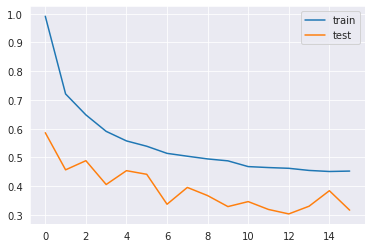

3
1
2
0
0
1
0
1
1
0
0
0
2
0
1
1
3
1
2
0
2
1
1
2
2
0
1
2
0
3
1
0
0
1
2
1
3
0
1
1
1
1
2
1
1
2
0
0
2
0
1
1
0
1
0
1
0
0
1
2
0
0
0
1
1
1
0
2
2
1
1
1
0
1
2
2
0
1
2
0
1
0
0
1
1
2
3
0
0
1
1
0
2
3
0
0
1
1
1
0
1
1
1
0
0
1
1
0
0
0
1
2
1
2
3
1
1
1
2
1
0
0
0
0
2
2
1
0
2
2
0
1
0
0
2
1
2
0
1
1
0
2
0
0
1
1
1
0
0
3
0
1
3
3
1
3
2
2
1
1
0
0
0
0
3
0
0
1
3
0
1
0
2
0
1
1
0
1
3
0
1
2
0
1
1
1
1
2
0
2
1
1
2
2
0
1
0
2
1
2
1
1
0
1
0
2
3
1
2
0
1
0
0
0
0
2
2
0
1
1
1
3
0
3
0
0
2
2
1
1
1
0
1
1
1
0
1
0
2
1
1
2
0
1
0
1
1
3
1
0
1
2
1
0
2
0
1
0
2
1
0
2
2
0
3
0
0
0
1
1
0
2
0
0
1
0
0
3
0
0
1
0
0
1
1
0
0
1
1
1
1
1
2
1
1
2
0
0
0
2
1
0
3
0
1
1
1
0
3
2
0
1
2
2
1
1
0
0
1
0
1
3
0
1
0
0
1
1
1
1
1
0
0
2
2
0
1
2
2
3
0
1
1
0
1
1
2
2
0
0
1
0
1
1
2
0
1
3
1
1
1
1
0
0
1
3
3
3
2
1
0
3
0
3
0
1
1
1
0
2
0
0
2
0
0
2
1
0
0
0
1
1
0
0
0
1
0
1
2
1
0
1
1
1
2
1
1
2
1
1
1
1
1
0
2
2
1
0
2
0
3
1
1
2
0
2
3
1
0
2
1
1
0
0
2
1
0
0
2
1
1
1
1
1
1
1
2
1
1
2
0
0
1
2
3
2
1
0
1
0


array([[0.26881786, 0.02507447, 0.03929053, ..., 0.93571882, 0.028605  ,
        0.94454688],
       [0.01413301, 0.94636907, 0.14817687, ..., 0.00485097, 0.94877561,
        0.01856778],
       [0.03385903, 0.01300247, 0.80792878, ..., 0.01810618, 0.01425389,
        0.0089046 ],
       [0.6831901 , 0.01555399, 0.00460382, ..., 0.04132402, 0.0083655 ,
        0.02798074]])

In [35]:
N=ReseuDeNeurone(X_train,Y_train,X_test,Y_test,X_validation,Y_validation,(10,8,4),'tanh',0.01,100)
write_prediction(N.prediction.T,'_NN_tanh10_8_4')
N.prediction

erreur validation= 0.8559888763863701
erreur validation= 0.5409190905412693
erreur validation= 0.4957255220892329
erreur validation= 0.3730171445556424
erreur validation= 0.346626995993822
erreur validation= 0.39386475435956947
erreur validation= 0.3461211585628629
erreur validation= 0.3358642365387167
erreur validation= 0.3405040505562523
erreur validation= 0.3290730155717034
erreur validation= 0.33650629533510584
erreur validation= 0.39902106144081245
erreur validation= 0.7600712921491116


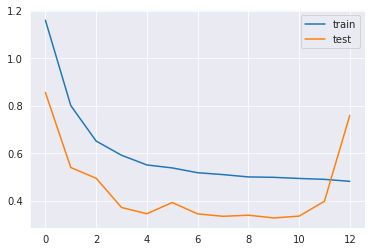

0
1
2
0
0
0
0
1
1
0
0
0
2
0
0
1
3
0
2
0
2
1
0
2
2
0
2
2
0
3
1
0
0
0
2
1
0
0
3
1
1
0
2
0
0
2
0
0
2
0
1
1
0
0
0
1
0
0
1
0
0
0
0
1
0
1
0
2
2
1
1
1
0
0
0
2
0
2
2
0
0
0
0
1
0
2
3
0
0
1
1
0
0
3
0
0
1
1
1
0
0
1
1
0
0
1
1
0
0
0
0
2
1
2
0
1
1
0
2
0
0
0
0
0
2
2
1
0
2
2
0
0
0
0
0
1
2
0
1
0
0
2
0
0
0
1
0
0
0
0
0
0
3
3
0
3
0
2
0
1
0
0
0
0
0
0
0
1
0
0
1
0
2
0
0
1
0
1
3
0
0
2
0
2
0
0
0
2
0
0
1
0
2
2
0
1
0
3
2
0
1
0
0
0
0
2
3
2
2
0
1
0
0
0
0
2
2
0
1
1
1
0
0
3
0
0
2
2
0
1
1
0
1
1
0
0
1
0
2
1
2
0
0
2
0
0
0
2
1
0
3
2
1
0
2
0
1
0
2
1
0
2
2
0
0
0
0
0
1
0
0
2
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
1
0
1
0
1
2
2
0
2
0
0
0
3
1
0
0
0
1
0
2
0
3
2
0
0
2
2
2
1
0
0
2
0
1
3
0
1
0
0
0
1
1
1
0
0
0
2
3
0
1
2
2
3
0
1
0
0
0
1
2
1
0
0
0
0
1
1
2
0
3
3
1
1
0
0
0
0
0
3
3
3
2
0
0
3
0
3
0
1
1
0
0
2
0
0
2
0
0
3
1
0
0
0
0
1
0
0
0
1
0
0
2
0
0
1
1
0
2
1
1
2
2
1
1
0
1
0
2
2
0
0
2
0
0
0
0
2
0
2
0
0
0
2
1
1
0
0
0
1
0
0
2
1
1
1
1
3
0
1
2
0
0
2
0
0
0
2
3
2
1
0
0
0


(4, 460)

In [36]:
N=ReseuDeNeurone(X_train,Y_train,X_test,Y_test,X_validation,Y_validation,(6,4),'tanh',0.01,100)
write_prediction(N.prediction.T,'_NN_tanh6_4')
N.prediction.shape

erreur validation= 0.9406613771169225
erreur validation= 0.7361644558192388
erreur validation= 0.5741012168120587
erreur validation= 0.43457079970929025
erreur validation= 0.5082143438495234
erreur validation= 0.4387940808340847
erreur validation= 0.37696261987232194
erreur validation= 0.4251584663047293
erreur validation= 0.3455219091748739
erreur validation= 0.3671958392615016
erreur validation= 0.4252023521596533
erreur validation= 0.39240236665301276


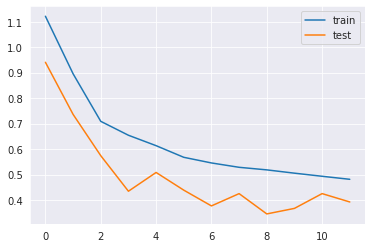

3
1
2
1
0
1
0
1
1
0
0
0
1
0
1
1
3
1
2
0
2
1
1
2
2
0
1
2
0
3
1
0
0
1
2
1
3
0
1
1
1
1
2
1
1
2
0
0
2
1
1
1
1
1
0
1
0
0
1
2
0
0
0
1
1
1
0
2
2
1
1
1
0
1
2
2
1
1
2
0
1
2
1
1
1
2
3
0
0
1
1
0
2
3
0
0
1
1
1
0
1
1
1
0
0
1
1
3
3
0
1
2
1
2
3
1
1
1
2
1
0
0
1
2
2
2
1
0
2
2
0
1
0
1
2
1
2
0
1
1
0
2
1
0
1
1
1
0
0
3
1
1
3
3
1
3
2
2
1
1
0
0
0
0
3
2
0
1
3
0
1
0
2
2
1
1
0
1
3
0
1
2
0
1
1
1
1
2
0
2
1
1
2
2
0
1
0
2
1
2
1
1
0
1
0
2
3
1
2
0
1
0
0
0
0
2
2
3
1
1
1
1
3
3
0
0
1
2
1
1
1
0
1
1
1
0
1
0
2
1
1
2
0
1
0
1
1
2
1
0
1
2
1
0
2
0
1
0
2
1
0
2
2
0
3
0
0
0
1
1
2
2
0
0
1
0
0
3
1
2
1
0
0
1
1
0
0
1
1
1
1
1
2
1
1
1
0
0
2
2
1
0
3
3
1
1
1
3
3
2
0
1
2
2
1
1
0
0
1
1
1
3
0
1
0
0
1
1
1
1
1
0
0
2
2
0
1
2
2
3
0
1
1
0
1
1
2
2
0
0
1
0
1
1
2
0
1
3
1
1
1
1
0
0
1
3
1
3
2
1
2
2
0
3
0
1
1
1
1
2
1
0
2
0
0
2
1
1
0
0
1
1
0
0
0
2
0
1
2
1
0
1
1
1
2
1
1
2
1
1
1
1
1
0
2
2
1
0
1
0
2
1
1
2
0
2
1
1
0
2
1
1
0
1
2
1
0
0
1
1
1
1
1
1
1
1
2
1
1
2
0
0
1
2
3
2
1
0
1
0


array([[0.34749222, 0.00479597, 0.03009122, ..., 0.92369834, 0.00978418,
        0.68239994],
       [0.00925713, 0.96624759, 0.27688093, ..., 0.00888218, 0.93494493,
        0.26254336],
       [0.1047816 , 0.01726051, 0.68116697, ..., 0.02753546, 0.03264018,
        0.02063772],
       [0.53846906, 0.01169593, 0.01186089, ..., 0.03988402, 0.0226307 ,
        0.03441898]])

In [37]:
N=ReseuDeNeurone(X_train,Y_train,X_test,Y_test,X_validation,Y_validation,(10,8,6),'tanh',0.01,100)
write_prediction(N.prediction.T,'_NN_tanh10_8_6')
N.prediction

### 1. prédiction relu

erreur validation= 0.8652771841485785
erreur validation= 0.7174282897485824
erreur validation= 0.5565569155616815
erreur validation= 0.47359441501356214
erreur validation= 0.4535342016709909
erreur validation= 0.4727248645244762
erreur validation= 0.4377748018966637
erreur validation= 0.4300209657988629
erreur validation= 0.43068962865994215
erreur validation= 0.41578567621332424
erreur validation= 0.5230333790641081
erreur validation= 0.4433624858481061
erreur validation= 0.41940794156554956


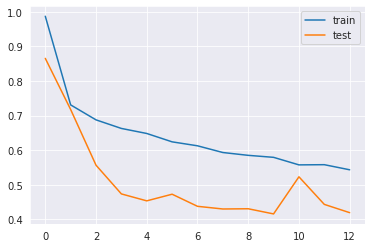

2
1
2
0
0
1
0
1
1
0
0
0
2
0
0
1
3
1
2
0
2
1
1
2
2
0
2
2
0
3
1
0
0
1
2
1
0
0
1
1
1
0
2
1
1
2
0
0
2
0
1
1
0
1
0
1
0
0
1
2
0
0
0
1
1
1
0
2
2
1
1
1
0
1
2
2
0
1
2
0
0
2
0
1
0
2
3
0
0
1
1
0
2
3
0
0
1
1
1
0
1
1
1
0
0
1
1
3
0
0
1
2
1
2
3
1
1
1
2
1
0
0
0
2
2
2
1
0
2
2
0
1
0
0
0
0
2
0
1
1
0
2
0
0
1
1
1
0
0
3
0
0
3
3
1
3
0
2
1
1
0
0
0
0
0
0
0
1
3
0
1
0
2
0
1
1
0
1
3
0
1
2
0
2
0
1
1
2
0
2
1
0
2
2
0
1
0
2
1
0
1
1
0
1
0
2
2
2
2
0
1
0
0
0
0
2
2
0
1
1
1
3
0
2
0
0
2
2
1
1
1
0
1
1
1
0
1
0
2
1
2
2
0
2
0
1
1
2
1
0
1
2
1
0
2
0
1
3
2
1
0
2
0
0
3
0
0
0
1
1
2
2
0
0
1
0
0
0
0
2
1
0
0
1
1
0
0
1
0
1
1
1
2
2
1
2
0
0
2
2
1
0
3
0
1
1
2
3
3
2
0
1
2
2
2
1
0
0
1
0
1
2
0
1
0
0
1
1
1
1
1
0
0
2
2
0
1
2
2
0
0
1
2
0
1
1
2
2
0
0
1
0
1
1
2
0
3
3
1
1
1
1
0
0
1
3
2
2
2
1
0
2
0
0
0
1
1
3
0
2
1
0
2
0
0
2
1
0
0
0
0
1
0
0
0
2
0
1
2
1
0
1
1
1
2
1
1
2
1
1
1
1
1
0
2
2
1
0
2
0
2
1
1
2
0
2
3
1
0
2
1
1
0
0
2
1
0
0
2
1
1
1
1
1
1
1
2
1
1
2
0
0
1
2
0
2
1
0
1
0


array([[4.13146662e-01, 5.46285434e-03, 1.32033983e-02, ...,
        9.70856713e-01, 5.36007503e-02, 9.99407483e-01],
       [3.32490069e-02, 9.81691321e-01, 2.15881847e-02, ...,
        3.84658733e-03, 8.56534519e-01, 1.41710413e-04],
       [4.29585884e-01, 6.96702312e-03, 9.54520819e-01, ...,
        1.44113852e-02, 5.73290764e-02, 1.01831438e-04],
       [1.24018447e-01, 5.87880147e-03, 1.06875979e-02, ...,
        1.08853147e-02, 3.25356545e-02, 3.48975317e-04]])

In [38]:
N=ReseuDeNeurone(X_train,Y_train,X_test,Y_test,X_validation,Y_validation,(10,8,6),'relu',0.01,100)
write_prediction(N.prediction.T,'_NN_relu10_8_6')
N.prediction

erreur validation= 0.9297364965525585
erreur validation= 0.8207423793314453
erreur validation= 0.6343022730171776
erreur validation= 0.6013739221739136
erreur validation= 0.5924142154600566
erreur validation= 0.6611740393929482
erreur validation= 0.5253195600592826
erreur validation= 0.4937782710047774
erreur validation= 0.47821263457744506
erreur validation= 0.838411731408972
erreur validation= 0.4670226320700814
erreur validation= 0.43155030934841554
erreur validation= 0.43983990581011007
erreur validation= 0.473570324807875
erreur validation= 0.5009920284230206


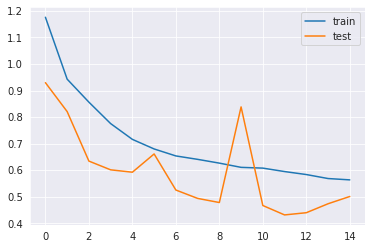

3
1
2
0
0
1
0
1
1
0
0
0
2
0
0
1
3
1
2
0
2
1
1
2
2
0
1
2
0
3
1
0
0
1
2
1
3
0
1
1
1
0
3
1
1
3
0
0
2
0
1
1
0
1
0
1
0
0
1
3
0
0
0
1
1
1
0
2
2
1
1
1
0
1
2
3
0
1
2
0
1
3
0
1
0
1
3
0
0
1
1
0
0
3
0
0
1
1
1
0
1
1
1
0
0
1
1
0
0
0
1
2
1
2
0
1
1
1
2
0
0
0
0
0
3
2
1
0
2
2
0
1
0
0
0
1
2
0
1
1
0
2
1
0
1
1
1
0
0
3
0
1
3
0
1
3
0
2
1
1
0
0
0
0
0
0
0
1
0
0
1
0
2
3
1
1
0
1
3
0
1
2
0
1
0
1
1
2
0
0
1
1
2
2
0
1
0
3
1
0
1
1
0
1
0
3
3
2
2
0
1
0
0
0
0
3
2
0
1
1
1
0
0
3
0
0
1
3
1
1
1
0
1
1
1
0
1
0
3
1
1
0
0
2
0
1
1
3
1
0
1
2
1
0
3
0
1
0
3
1
0
2
2
0
3
0
0
0
1
1
0
2
0
0
1
0
0
3
0
0
1
0
0
1
1
0
0
1
0
1
1
1
2
2
1
1
0
0
0
2
1
0
0
0
1
1
1
0
0
2
0
1
2
2
1
1
0
0
1
0
1
3
0
1
0
0
1
1
1
1
1
0
0
2
3
0
1
2
2
3
0
1
1
0
0
1
2
1
0
0
1
0
1
1
2
0
0
3
1
1
1
1
0
0
1
3
1
3
2
1
0
3
0
3
0
1
1
1
0
2
0
0
2
0
0
2
1
0
0
0
0
1
0
0
0
1
0
2
2
1
0
1
1
1
2
1
1
2
1
1
1
1
1
0
2
2
0
0
2
0
3
1
1
2
0
2
0
1
0
2
1
1
0
0
3
1
0
0
1
1
1
1
1
1
1
1
2
1
1
2
0
0
0
2
3
2
1
0
1
0


array([[4.63762761e-01, 3.22829128e-02, 3.03426778e-02, ...,
        9.27188877e-01, 3.62894606e-02, 9.75850326e-01],
       [2.19372984e-04, 9.10104795e-01, 3.46163091e-01, ...,
        1.17434446e-03, 8.87691212e-01, 5.25333309e-04],
       [5.59992274e-02, 4.60610409e-02, 5.51819622e-01, ...,
        2.88462737e-03, 6.10467665e-02, 3.89667836e-04],
       [4.80018638e-01, 1.15512512e-02, 7.16746093e-02, ...,
        6.87521508e-02, 1.49725613e-02, 2.32346724e-02]])

In [39]:
N=ReseuDeNeurone(X_train,Y_train,X_test,Y_test,X_validation,Y_validation,(10,8,4),'relu',0.01,100)
write_prediction(N.prediction.T,'_NN_relu10_8_4')
N.prediction

erreur validation= 0.9229234724818434
erreur validation= 0.6554785365798714
erreur validation= 0.5852858801282071
erreur validation= 0.5007151324866014
erreur validation= 0.5527841998614071
erreur validation= 0.5112505067510009
erreur validation= 0.5540836434104763


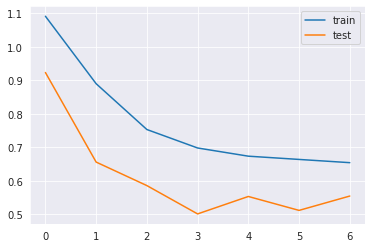

0
1
1
0
0
1
0
1
1
0
0
0
1
0
0
1
0
1
0
0
2
1
1
0
2
0
1
2
0
0
1
0
0
1
0
1
0
0
1
1
1
0
2
1
1
2
0
0
2
0
1
1
0
1
0
1
0
0
1
0
0
0
0
1
1
1
0
2
2
1
1
1
0
1
0
2
0
1
2
0
0
0
0
1
0
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
1
1
1
0
0
1
1
0
0
0
1
2
1
2
0
1
1
1
2
0
0
0
0
2
2
0
1
0
2
2
0
1
0
0
0
1
2
0
1
1
0
2
0
0
1
1
1
0
0
0
0
0
0
0
1
0
0
2
1
1
0
0
0
0
0
0
0
1
0
0
1
0
2
0
1
1
0
1
0
0
1
2
0
1
0
1
0
0
0
0
1
1
2
2
0
1
0
2
1
0
1
1
0
1
0
0
0
1
2
0
1
0
0
0
0
0
2
0
1
1
1
0
0
0
0
0
1
2
1
1
1
0
1
1
1
0
1
0
2
1
1
0
0
1
0
0
0
2
1
0
1
2
1
0
0
0
1
0
2
1
0
2
0
0
0
0
0
0
1
1
0
2
0
0
1
0
0
0
0
0
1
0
0
1
1
0
0
1
0
1
1
1
2
2
1
1
0
0
0
0
1
0
0
0
1
1
1
0
0
2
0
1
2
2
1
1
0
0
1
0
1
0
0
1
0
0
1
1
1
1
1
0
0
2
2
0
1
2
2
0
0
1
1
0
1
1
0
1
0
0
1
0
1
1
1
0
1
0
1
1
1
1
0
0
1
0
1
0
2
1
0
2
0
0
0
1
1
1
0
2
1
0
2
0
0
2
1
0
0
0
0
1
0
0
0
1
0
1
2
1
0
1
1
1
2
1
1
2
1
1
1
1
1
0
2
2
1
0
1
0
0
1
1
2
0
2
2
1
0
2
1
1
0
0
0
1
0
0
1
1
1
1
1
1
1
1
2
1
1
2
0
0
0
2
0
1
1
0
1
0


array([[7.16264507e-01, 8.40131571e-03, 7.22466024e-02, ...,
        8.70780926e-01, 1.11545154e-01, 9.82621492e-01],
       [6.57932877e-03, 9.80918481e-01, 4.39213836e-01, ...,
        2.84075936e-03, 8.00164992e-01, 8.05924211e-04],
       [4.34527406e-02, 2.71572544e-03, 3.51512084e-01, ...,
        9.50140641e-03, 2.09264811e-02, 7.79161760e-05],
       [2.33703424e-01, 7.96447736e-03, 1.37027477e-01, ...,
        1.16876909e-01, 6.73633729e-02, 1.64946679e-02]])

In [40]:
N=ReseuDeNeurone(X_train,Y_train,X_test,Y_test,X_validation,Y_validation,(6,4),'relu',0.01,100)
write_prediction(N.prediction.T,'_NN_relu6_4')
N.prediction